In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderNotFound
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
from sklearn.cluster import KMeans

print("All libs imported")

All libs imported


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df=pd.read_csv("Population by travel zone 2011-2056.csv")
df.head()

,TZ_CODE11,TZ_NAME11,SA2_11,SA2_NAME11,SA3_11,SA3_NAME11,SA4_11,SA4_NAME11,GSC District,LGA 2011 NAME,Precinct (Oct 16),ERP_2011,ERP_2016,ERP_2021,ERP_2026,ERP_2031,ERP_2036,ERP_2041,ERP_2046,ERP_2051,ERP_2056
0,900,Ashfield_Frederick St and Henry St,120031390,Ashfield,12003,Strathfield - Burwood - Ashfield,120,Sydney - Inner West,Central,Ashfield (A),Ashfield (Rem),3375.00,3424.30,3456.40,3469.48,3487.53,3509.04,3671.64,3823.51,3917.87,4116.82
1,901,Ashfield_Chandos St and Loftus St,120031390,Ashfield,12003,Strathfield - Burwood - Ashfield,120,Sydney - Inner West,Central,Ashfield (A),Ashfield (Rem),3481.00,3865.82,3902.31,3927.42,3964.85,4010.53,4142.02,4231.12,4298.40,4515.50
2,902,Ashfield Station_North,120031390,Ashfield,12003,Strathfield - Burwood - Ashfield,120,Sydney - Inner West,Central,Ashfield (A),Ashfield,4103.00,4425.77,4488.38,4521.20,4568.33,4625.03,4732.76,4793.99,4863.63,5109.73
3,903,Ashfield Park,120031390,Ashfield,12003,Strathfield - Burwood - Ashfield,120,Sydney - Inner West,Central,Ashfield (A),Ashfield,1737.00,1949.65,1998.03,2043.99,2112.46,2192.26,2316.50,2346.23,2378.00,2501.85
4,904,Ashfield Station_South,120031390,Ashfield,12003,Strathfield - Burwood - Ashfield,120,Sydney - Inner West,Central,Ashfield (A),Ashfield,2762.18,3151.99,4212.64,4619.24,5058.40,5327.75,6098.54,6881.74,8023.30,8542.04


In [4]:
#Remove Newcastle and Wollongong areas
df.drop(df[df['GSC District'].isin(['xGSC Newcastle','xGSC Wollongong'])].index,axis=0,inplace=True)
df.shape

(2345, 21)

In [5]:
print("There are {} Travel Zones, {} SA2, {} SA3, {} SA4 and {} GSC District".format(len(df['TZ_NAME11'].unique()), len(df['SA2_NAME11'].unique()),len(df['SA3_NAME11'].unique()),len(df['SA4_NAME11'].unique()),len(df['GSC District'].unique())))

There are 2345 Travel Zones, 249 SA2, 45 SA3, 14 SA4 and 6 GSC District


We will use Statistical Areas(SA) 2 for our analysis. This geography is approximately the same size of a suburb and is useful for reporting and reviewing of results at a local neighbourhood level.

In [322]:
#Get Latitude and Longitude for suburbs
address= df['SA2_NAME11'].apply(lambda x: x.split('-')[-1]+', NSW, Australia').unique()
geolocater= Nominatim(user_agent="sydney-explorer")
location=[]
empty=[]

def getcoords(add):
    try:
        coords= geolocater.geocode(add, timeout=10)
        location.append([add, coords.latitude, coords.longitude])
        print("the coords are {}".format(location[-1]))
    
    except GeocoderTimedOut:
        return getcoords(add)
    
    except:
        empty.append([add])
        print("Couldn't find coords of {}".format(empty[-1]))
        
for add in address:
        getcoords(add)       

the coords are ['Ashfield, NSW, Australia', -33.8894781, 151.1274125]
the coords are [' Summer Hill, NSW, Australia', -33.8933952, 151.1368729]
the coords are ['Auburn, NSW, Australia', -33.8545702, 151.0255673]
the coords are [' Silverwater, NSW, Australia', -33.834881, 151.0471218]
the coords are [' Regents Park, NSW, Australia', -33.8820048, 151.02569]
the coords are ['Rookwood Cemetery, NSW, Australia', -33.87443545, 151.055890768901]
the coords are [' Sefton, NSW, Australia', -33.8873088, 151.0106256]
the coords are ['Bankstown, NSW, Australia', -33.9171897, 151.0335881]
the coords are [' Georges Hall, NSW, Australia', -33.9101113, 150.9879924]
the coords are ['Chullora, NSW, Australia', -33.8925, 151.0477778]
the coords are ['Condell Park, NSW, Australia', -33.9227852, 151.0113144]
the coords are [' Mount Lewis, NSW, Australia', -33.9156089, 151.0499433]
the coords are ['Padstow, NSW, Australia', -33.9487767, 151.030116]
the coords are [' Picnic Point, NSW, Australia', -33.970955

the coords are [' Killara, NSW, Australia', -33.7660606, 151.1601121]
the coords are [' Roseville, NSW, Australia', -33.7826456, 151.1827257]
the coords are ['Pymble, NSW, Australia', -33.7450185, 151.1424708]
the coords are ['St Ives, NSW, Australia', -33.7258869, 151.1727212]
the coords are ['Turramurra, NSW, Australia', -33.7354346, 151.1300645]
the coords are [' Warrawee, NSW, Australia', -33.7279732, 151.1232279]
the coords are [' Lane Cove North, NSW, Australia', -33.8059265, 151.1617117]
the coords are [' Greenwich, NSW, Australia', -33.8300104, 151.1855621]
the coords are ['Balmain, NSW, Australia', -33.8583992, 151.1807353]
the coords are [' Annandale, NSW, Australia', -33.881224, 151.1709976]
the coords are [' Rozelle, NSW, Australia', -33.8645002, 151.1743543]
the coords are [' Miller, NSW, Australia', -33.9205556, 150.8805556]
the coords are [' Greendale, NSW, Australia', -34.69, 149.1511111]
the coords are [' Cecil Hills, NSW, Australia', -33.89, 150.8511111]
the coords ar

the coords are [' Belrose, NSW, Australia', -33.730009, 151.2191438]
the coords are [' Brookvale, NSW, Australia', -33.7628854, 151.2707024]
the coords are [' Allambie Heights, NSW, Australia', -33.7705067, 151.249675]
the coords are [' Collaroy, NSW, Australia', -33.7382194, 151.2996618]
the coords are [' Duffys Forest, NSW, Australia', -33.6733265, 151.1927796]
the coords are [' Bronte, NSW, Australia', -33.9042128, 151.2637774]
the coords are [' North Bondi, NSW, Australia', -33.882351, 151.2768611]
the coords are [' Waverly, NSW, Australia', -31.8736606, 151.078754158088]
the coords are ['Dover Heights, NSW, Australia', -33.8739831, 151.2810366]
the coords are [' Artarmon, NSW, Australia', -33.8094124, 151.1857609]
the coords are [' Naremburn, NSW, Australia', -33.8171309, 151.2020304]
the coords are [' Northbridge, NSW, Australia', -33.8111111, 151.2175]
the coords are ['Bargo, NSW, Australia', -34.293747, 150.5817842]
the coords are [' Appin, NSW, Australia', -34.2029671, 150.787

In [324]:
len(location)

243

In [584]:
#Convert location list to Dataframe and save in a csv
df_loc= pd.DataFrame(location, columns=['Area','Latitude','Longitude'])
df_loc.to_csv('area_location.csv')
df_loc.head()

,Area,Latitude,Longitude
0,"Ashfield, NSW, Australia",-33.889478,151.127412
1,"Summer Hill, NSW, Australia",-33.893395,151.136873
2,"Auburn, NSW, Australia",-33.854570,151.025567
3,"Silverwater, NSW, Australia",-33.834881,151.047122
4,"Regents Park, NSW, Australia",-33.882005,151.025690


In [6]:
trythis='The Rocks, NSW, Australia'
#we will use this location as center of our map
geolocater= Nominatim(user_agent="dummy-exp")
center= geolocater.geocode(trythis)
lat= center.latitude
lon= center.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(trythis,lat, lon))

The geograpical coordinate of The Rocks, NSW, Australia are -33.859992, 151.2083216.


Lets create a map of Sydney GMA marked with all suburbs

In [10]:
map_nsw=folium.Map(location=[lat,lon],zoom_start=8)
for lat, long, area in zip(df_loc['Latitude'], df_loc['Longitude'],df_loc['Area']):
    label=folium.Popup(area, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=1,
        popup=label,
        color='blue',
        fill=False,
        fill_color='blue',
        fill_opacity=1,
        parse_html=False).add_to(map_nsw)
    
map_nsw    

### Methodology

### Venues and categories
<p>We will use Foursquare API to explore venue categories in each area. Venues can be categorized as residential, professional, shopping or leisure. Let's see what venue categories Foursquare identifies.</p>

In [17]:
CLIENT_ID = 'SBYXW1BUNN5KYALPMMGA3MALKOFWE43BPWW2J4IDOKGXB3QC' # your Foursquare ID
CLIENT_SECRET = 'S3QKND2Y2HRCHYS2RDOHJYS25ZCKXYOWQ4YAVXZILDRINPUK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [18]:
#gwtting high level categories
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [19]:
len(results['response']['categories'])

10

There are 10 top level categories. There are multiple sub categories but we will not explore it for the time

In [20]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


Now we use <b>explore</b> option with categoryId to query the number of venues of each category in a specific radius. The response contains a <b>totalResults</b> value for the specified coordinates, radius and category.

In [211]:
def get_venues_count(lat,long, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                long,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']


In [413]:
#Create new dataframe to store venues data
df_venues = df_loc.copy()
for c in categories_list:
    df_venues[c[0]] = 0
    
df_venues.head()    

,Area,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,"Ashfield, NSW, Australia",-33.889478,151.127412,0,0,0,0,0,0,0,0,0
1,"Summer Hill, NSW, Australia",-33.893395,151.136873,0,0,0,0,0,0,0,0,0
2,"Auburn, NSW, Australia",-33.854570,151.025567,0,0,0,0,0,0,0,0,0
3,"Silverwater, NSW, Australia",-33.834881,151.047122,0,0,0,0,0,0,0,0,0
4,"Regents Park, NSW, Australia",-33.882005,151.025690,0,0,0,0,0,0,0,0,0


In [ ]:
#Request number of venues, store result as CSV
for i, row in df_venues.iterrows():
    for c in categories_list:        
        df_venues.loc[i, c[0]] = get_venues_count(df_venues.Latitude.iloc[i], df_venues.Longitude.iloc[i], radius=1000, categoryId=c[1])
    print(i)
    df_venues.to_csv('area_venues.csv')

In [4]:
import pandas as pd
df_venues=pd.read_csv('area_venues.csv', index_col=0)
df_venues.head()

,Area,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,"Ashfield, NSW, Australia",-33.889478,151.127412,9,3,0,43,6,11,18,7,29,4
1,"Summer Hill, NSW, Australia",-33.893395,151.136873,9,2,0,31,4,12,15,7,20,10
2,"Auburn, NSW, Australia",-33.854570,151.025567,1,7,0,19,2,7,9,3,16,4
3,"Silverwater, NSW, Australia",-33.834881,151.047122,3,1,0,27,0,4,18,1,13,8
4,"Regents Park, NSW, Australia",-33.882005,151.025690,1,2,0,6,1,3,4,1,3,3


# Exploratory Data Analysis

Lets make a box plot for Venues

Normalize the data using MinMaxScaler (scale from 0 to 1). This scales the data and provides an easy to interpret score at the same time.

In [12]:
from sklearn.preprocessing import MinMaxScaler

X = df_venues.values[:,3:]
scaled_dataset = MinMaxScaler().fit_transform(X)

In [21]:
df_scaled = pd.DataFrame(scaled_dataset)
df_scaled.columns = [c[0] for c in categories_list]
df_scaled.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.209302,0.030303,0.0,0.176955,0.045113,0.118280,0.116883,0.212121,0.219697,0.033898
1,0.209302,0.020202,0.0,0.127572,0.030075,0.129032,0.097403,0.212121,0.151515,0.084746
2,0.023256,0.070707,0.0,0.078189,0.015038,0.075269,0.058442,0.090909,0.121212,0.033898
3,0.069767,0.010101,0.0,0.111111,0.000000,0.043011,0.116883,0.030303,0.098485,0.067797
4,0.023256,0.020202,0.0,0.024691,0.007519,0.032258,0.025974,0.030303,0.022727,0.025424


Box plot of scaled data

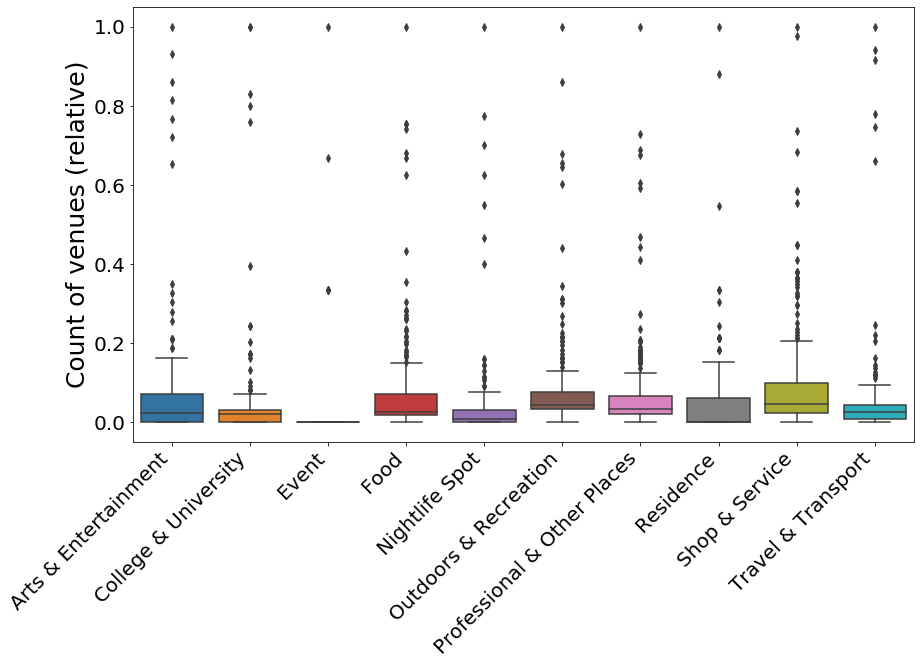

In [22]:
plt.figure(figsize=(14,8))
ax = sns.boxplot(data = df_scaled)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

Many outliers there! Food, Shops and Professional areas are frequent. Thre's too little data for <b>Event</b> so let's just drop that category.

In [26]:
df_venues.drop('Event', 1, inplace=True)
categories_list.remove(('Event', '4d4b7105d754a06373d81259'))

# Clustering
We'll be using k-means clustering. These were preliminary results with different number of clusters:
<ul>
<li>2 clusters only show the uptown/downtown divide</li>
<li>3 clusters add clustering within the downtown</li>
<li>4 clusters add clustering within uptown and downtown</li>
<li>5 and more clusters are difficult to interpret</li>
<li>For the final analysis we settle on 4 clusters</li>
    </ul>

In [27]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_scaled)

kmeans_labels = kmeans.labels_

df_venues_clustered = df_venues.copy()
df_venues_clustered['Cluster'] = kmeans_labels

#dataframe to be used for box plot
df_scaled_clustered = df_scaled.copy()
df_scaled_clustered['Cluster'] = kmeans_labels

Visualize the clusters with boxplots

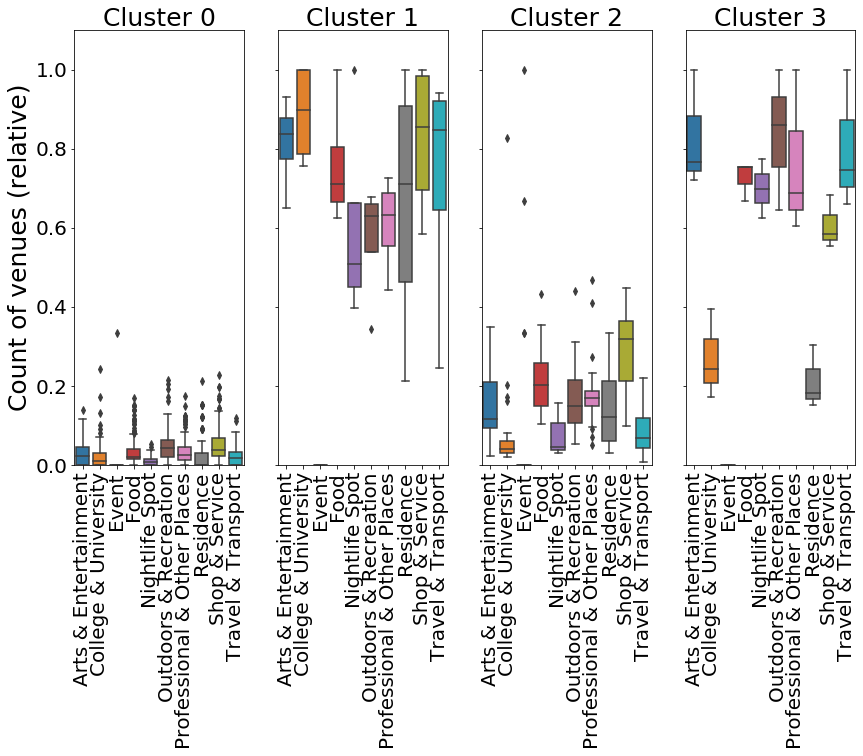

In [28]:
fig,axes= plt.subplots(1,kclusters,figsize=(14,8),sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(0, kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = df_scaled_clustered[df_scaled_clustered['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [588]:
map_sydney_gma = folium.Map(location=[lat,lon],zoom_start=10)

#add markers
for i, area, lat, long, cluster in zip(df_venues_clustered.index,
                                         df_venues_clustered['Area'],
                                         df_venues_clustered['Latitude'],
                                         df_venues_clustered['Longitude'],
                                         df_venues_clustered['Cluster']):   
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['blue','green','red','magenta']
    folium.CircleMarker(
        [lat,long],
        fill=True,
        fill_opacity=1,
        popup=folium.Popup(area, parse_html=True),
        radius=2,
        color=colors[cluster]
    ).add_to(map_sydney_gma)
    
    
      
map_sydney_gma

Here is how we can understand these clusters:
<ul>
<li>Cluster 0 (blue) has low frequencies for all venue categories. These appear to be underdeveloped neighborhoods</li>
<li>Cluster 1 (green) has consistently high frequencies for all venue categories. This is the most diversely developed part of city</li>
<li>Cluster 2 (red) has moderate scores with shops and services being the most popular. These are developed residential suburbs</li>
<li>Cluster 3 (magenta) has high frequencies but with less residential places and more professional places. These are the developed professional or industrial suburbs.</li>
    </ul>

Now we look at the population dataset. For our analysis we consider data from 2016-2036

In [30]:
years=['ERP_2016','ERP_2021','ERP_2026','ERP_2031','ERP_2036']
df_population=df.loc[:,years]
df_population['Area']=df['SA2_NAME11']
df_population.shape

(2345, 6)

In [31]:
 #get total population of each neighborhood
df_population=df_population.groupby('Area').sum()
df_population.reset_index(inplace=True)

# Format area column. Will be useful for merging dataframes later
df_population['Area']=df_population['Area'].apply(lambda x: x.split('-')[-1]+', NSW, Australia')


#Add a column for % increase in population growth from 2016-2036
df_population['growth']=round(((df_population['ERP_2036']-df_population['ERP_2016'])/df_population['ERP_2016']),2)

In [537]:
df_population.shape

(249, 7)

In [32]:
#Let's bring everything together
df_all= df_venues_clustered.merge(df_population, on='Area', how='left')

In [539]:
df_all.shape

(239, 19)

In [33]:
#get neighborhoods with at least 60% population expansion
df_expansion_areas=df_all.drop(df_all[df_all['growth']<0.6].index,axis=0)
df_expansion_areas.drop(df_expansion_areas[df_expansion_areas['ERP_2036']<1000].index,axis=0,inplace=True)
df_expansion_areas

,Area,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Cluster,ERP_2016,ERP_2021,ERP_2026,ERP_2031,ERP_2036,growth
3,"Silverwater, NSW, Australia",-33.834881,151.047122,3,1,27,0,4,18,1,13,8,0,19576.23,33403.18,44712.25,54791.91,65237.24,2.33
9,"Chullora, NSW, Australia",-33.892500,151.047778,0,1,6,1,4,7,0,9,3,0,942.13,1225.07,1436.06,1559.22,1668.38,0.77
19,"Marsden Park, NSW, Australia",-33.695655,150.814797,0,0,1,0,1,0,1,5,0,0,17812.15,39896.18,69856.66,98760.38,131013.55,6.36
26,"Kings Park, NSW, Australia",-33.743333,150.908611,2,4,6,4,2,4,1,10,3,0,17519.33,19842.57,23379.51,27165.46,31690.89,0.81
49,"Leppington, NSW, Australia",-33.954386,150.808064,1,1,0,0,0,4,0,0,5,0,18365.16,38861.72,69658.98,103414.00,141275.25,6.69
52,"Denham Court, NSW, Australia",-33.981389,150.829444,0,0,1,0,0,0,0,0,0,0,20714.95,25730.31,29687.06,31832.37,33746.53,0.63
56,"Glen Alpine, NSW, Australia",-34.090000,150.784444,1,2,5,1,6,4,0,4,0,0,21361.84,22473.76,28356.55,34221.76,40764.12,0.91
61,"Ashbury, NSW, Australia",-33.900111,151.118072,1,4,4,1,4,3,3,9,4,0,10970.69,13442.22,16072.37,18728.01,21247.01,0.94
63,"Campsie, NSW, Australia",-33.914389,151.103213,1,5,19,4,4,13,2,17,4,0,31951.83,38132.86,46003.97,53277.66,59649.67,0.87
82,"McGraths Hill, NSW, Australia",-32.448250,152.391620,0,0,0,0,0,0,0,0,0,0,10821.71,12388.30,15125.63,18290.63,22305.38,1.06


In [587]:
map_expanding_clusters=folium.Map(location=[lat,lon],zoom_start=10)

#add markers
for area, lat, long, cluster in zip(df_venues_clustered['Area'],
                                    df_venues_clustered['Latitude'],
                                    df_venues_clustered['Longitude'],
                                    df_venues_clustered['Cluster']):   
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['blue','green','red','cyan']
    folium.CircleMarker(
        [lat,long],
        fill=True,
        fill_opacity=1,
        radius=2,
        color=colors[cluster]
    ).add_to(map_expanding_clusters)
    
for lat, long, area, rad in zip(df_expansion_areas['Latitude'], 
                                df_expansion_areas['Longitude'],
                                df_expansion_areas['Area'],
                                df_expansion_areas['growth']):
    label=folium.Popup('{}, {}%'.format(area,rad*100), parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=4+rad*3,
        popup=label,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.3,
        weight=1.5,
        parse_html=False).add_to(map_expanding_clusters)
    
map_expanding_clusters

In [571]:
map_expanding_clusters.save('expanding_neighborhoods_sydney.html')

We see a lot of blue clusters showing significant population growth. These are our areas of interest. Let's see how they compare to rest of the city

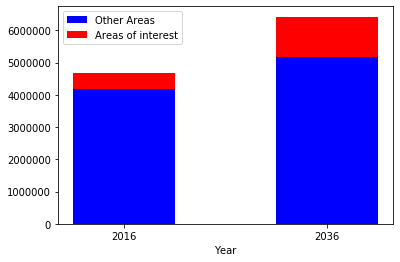

In [589]:
total_population_2016 = df['ERP_2016'].sum()
total_population_2036 = df['ERP_2036'].sum()
cluster_popultion = df_expansion_areas.groupby('Cluster')['ERP_2016','ERP_2036'].sum()
cluster_popultion_2016=cluster_popultion.loc[0][0]
cluster_popultion_2036=cluster_popultion.loc[0][1]
bar1=[(total_population_2016-cluster_popultion_2016),(total_population_2036-cluster_popultion_2036)]
bar2=[cluster_popultion_2016,cluster_popultion_2036]
r=[0,2]
names=['2016','2036']
width=1

plt.bar(r, bar1, color='blue', width=width)
plt.bar(r, bar2, bottom=bar1, color='red', width=width)
plt.xticks(r, names)
plt.xlabel("Year")
plt.legend(['Other Areas','Areas of interest']) 
plt.show()

In [580]:
percin2016= round((cluster_popultion_2016/total_population_2016)*100,2)
percin2036= round((cluster_popultion_2036/total_population_2036)*100,2)
print('{} less developed clusters that host {}% of city\'s population in 2016 will grow to host {}% of total population in 2036'.format(df_expansion_areas.groupby('Cluster').size()[0],percin2016,percin2036))

26 less developed clusters that host 10.7% of city's population in 2016 will grow to host 19.39% of total population in 2036


In [590]:
total_population_2036

6421844.2

# Results

From our analysis we found that very few neighborhoods of Sydney can be classified as highly developed based on venues data from Foursquare API. But with population projection data we see that urban footprint of Sydney will expand as new growth areas establish to the <b>North West and South West</b> of Sydney. Small scale incremental developments will provide for population growth within the existing urban footprint.

<b>26 currenty underdeveloped neighborhoos' contribution to the city's total population will rise from 10.7% to around 20%. </b> This shows not just growth but also a shift or spread of population towards these areas

<b>Mardsen Park</b> and <b>Leppington</b> emerge as the major growing areas and might even see a transformation from underdeveloped to downtown/ uptown as its land usage increases.

Predicting this growth pattern leads us to identify early business and service opportunities in currently underdeveloped areas. However, to understand its full impact we to categorize population data further. Still, a growth of this scale will have fundamental implication on venues belonging to categories <b>Residence, Shop & Service and Food</b> which benefit positively from population shift and expansion.


# Discussion and Recommendations

Our aim was to identify early opportunities in less developed or underdeveloped neighborhoods that are set to grow in future. 

It would be interesting to further study how popuation segments disaggregate by private and non-private dwellings, age-sex, household types, enrolments and workforce status. Fortunately, ABS census data and ABS Laborforce Survey Data is available  which can be used for futher analysis and getting deeper insights into the future of these neighborhoods.